# Scalar Property in the UTC

In [1]:
import os
import sys

%pylab inline
import pylab

import nengo
from nengo.utils.ensemble import response_curves, tuning_curves
import nengo_spa as spa
import nengolib
import nengo_extras
import pytry

import numpy as np
import pandas as pd
import itertools
import string
import scipy

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rcParams['lines.marker'] = ''
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.handlelength'] = 3


In [3]:
# UTC_prospective contains main functions for simulating the UTC model
%run ../UTC_prospective.py

## Scalar Property

### Time Production

In [4]:
# set parameters
n_trials = 100
dimensions_list = np.array([1])
target_intervals = np.logspace(-2, 2, num=9, base=2)
between_gain_noise_std = np.arange(0.0, 0.015, 0.005)
within_gain_noise_std = np.arange(0.0, 1.2, 0.4)
input_noise = np.arange(0, 1.2, 0.4)

# How to get data? simulate or load_raw
get_dat_method = 'load_raw'

In [5]:
%%capture

if get_dat_method == 'simulate':
    trial = 0
    for i in range(0, n_trials):
        for target_interval, dimensions, bg_std, wg_std, u_noise,  in itertools.product(target_intervals, 
                                                                     dimensions_list,
                                                                     between_gain_noise_std,
                                                                     within_gain_noise_std,
                                                                     input_noise):
            UTC_prospective().run(task_type='prospective_motor',
                                 dimensions=dimensions,
                                 prestim=0.,
                                 verbose=False,
                                 seed=trial,
                                 effective_theta=target_interval,
                                 full_output=False,
                                 between_gain_noise_std=bg_std,
                                 within_gain_noise_std=wg_std, 
                                 input_noise_std=u_noise,
                                 data_dir='scalar_motor')
            trial += 1
    
    scalar_motor_data = pytry.read('scalar_motor')
    scalar_motor_dt_raw = pd.DataFrame(scalar_motor_data)
    scalar_motor_dt_raw.to_csv('scalar_motor_dt_raw.csv')

In [6]:
scalar_motor_dt_raw = pd.read_csv('scalar_motor_dt_raw.csv')

In [7]:
# The raw data requires some processing to assess the scalar property; here we compute:
# - mean, mean squared
# - variance and standard deviation
# - Coefficient of Variation (CV)
scalar_motor_dt = pd.DataFrame()
var_independent = 0.000 # variance independent of target time
scalar_motor_dt['mean'] = scalar_motor_dt_raw.groupby(['effective_theta', 'between_gain_noise_std', 'within_gain_noise_std', 'input_noise_std'])['rt'].mean()
scalar_motor_dt['mean^2'] = scalar_motor_dt['mean']**2
scalar_motor_dt['var'] = scalar_motor_dt_raw.groupby(['effective_theta', 'between_gain_noise_std', 'within_gain_noise_std', 'input_noise_std'])['rt'].var() 
scalar_motor_dt['var'] = scalar_motor_dt['var'] + var_independent
scalar_motor_dt['std'] = np.sqrt(scalar_motor_dt['var'])
scalar_motor_dt['cv'] = scalar_motor_dt['std'] / scalar_motor_dt['mean']
scalar_motor_dt = scalar_motor_dt.reset_index()


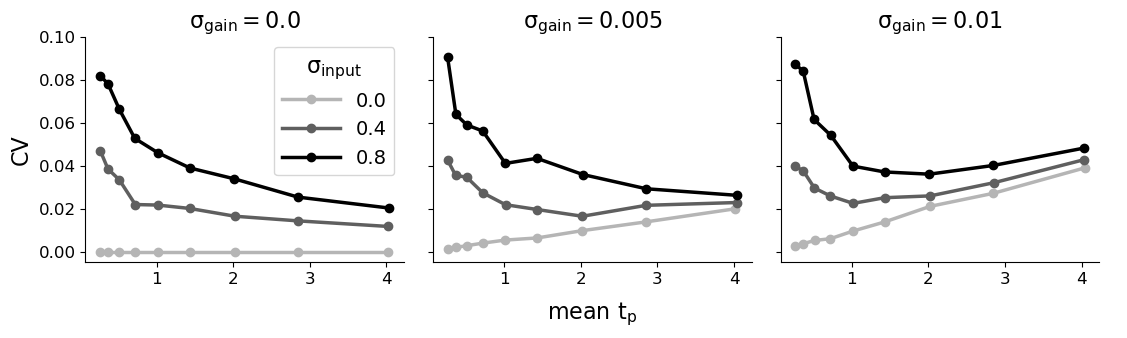

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True, sharex=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.xlabel(r'$mean\ t_p$', fontsize=16)
ax[0].set_ylabel('CV', fontsize=16)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

title = r'$\sigma_{{gain}} = {}$'
colors = plt.cm.Greys(np.linspace(0.4, 1, 3))
for i in range(0,len(between_gain_noise_std)):
    for j in range(0, len(input_noise)):
        conditions = (scalar_motor_dt['between_gain_noise_std']==between_gain_noise_std[i]) & (scalar_motor_dt['input_noise_std']==input_noise[j]) & (scalar_motor_dt['within_gain_noise_std']==0) 
        x = scalar_motor_dt[conditions]['mean'].values
        cv = scalar_motor_dt[conditions]['cv'].values
        
        ax[i].plot(x/1000, cv, lw=2.5, color=colors[j],
                   label=str(input_noise[j]),
                   marker='o')
        
        ax[i].set_title(title.format(between_gain_noise_std[i]),
                       fontsize=16)
        ax[i].set_ylim([-0.005, 0.1])
        
        ax[i].tick_params(axis='both', which='major', labelsize=12)
        ax[i].tick_params(axis='both', which='minor', labelsize=12)
        
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)

legend = ax[0].legend(title=r'$\sigma_{input}$', fontsize=14)
plt.setp(legend.get_title(),fontsize=16)
        
#plt.suptitle('Time Production', y=1.05, fontsize=18)
fig.tight_layout()
#plt.savefig('cvplot_prospective_motor.png', dpi=400)
#fig.savefig('cvplot_prospective_motor.tiff', dpi=1000, bbox_inches='tight')


### Time Perception

In [9]:
# set parameters
n_trials = 100
dimensions_list = np.array([1])
target_intervals = np.logspace(-2, 2, num=9, base=2)
between_gain_noise_std = np.arange(0.0, 0.015, 0.005)
within_gain_noise_std = np.arange(0.0, 1.2, 0.4)
input_noise = np.arange(0, 1.2, 0.4)

# How to get data? simulate, load_raw, or load agg_data
get_dat_method = 'load_raw'

In [10]:
%%capture
if get_dat_method == 'simulate':

    trial = 0
    for i in range(0, n_trials):
        for target_interval, dimensions, bg_std, wg_std, u_noise,  in itertools.product(target_intervals, 
                                                                     dimensions_list,
                                                                     between_gain_noise_std,
                                                                     within_gain_noise_std,
                                                                     input_noise):
            UTC_prospective().run(task_type='prospective_sensory',
                                 dimensions=dimensions,
                                 verbose=False,
                                 prestim=0.,
                                 seed=trial,
                                 effective_theta=target_interval,
                                 trial_duration=target_interval,
                                 full_output=False,
                                 between_gain_noise_std=bg_std,
                                 within_gain_noise_std=wg_std, 
                                 input_noise_std=u_noise,
                                 data_dir = 'scalar_sensory')
            trial += 1
            
    scalar_sensory_data = pytry.read('scalar_sensory')
    scalar_sensory_dt_raw = pd.DataFrame(scalar_sensory_dt_raw)
    scalar_sensory_dt_raw.to_csv('scalar_sensory_dt_raw.csv')

In [11]:
scalar_sensory_dt_raw = pd.read_csv('scalar_sensory_dt_raw.csv')

In [12]:
# The raw data requires some processing to assess the scalar property; here we compute:
# - mean, mean squared
# - variance and standard deviation
# - Coefficient of Variation (CV)
scalar_sensory_dt = pd.DataFrame()
var_independent = 0.000
scalar_sensory_dt['mean'] = scalar_sensory_dt_raw.groupby(['effective_theta', 'between_gain_noise_std', 'within_gain_noise_std', 'input_noise_std'])['estimate'].mean()
scalar_sensory_dt['mean^2'] = scalar_sensory_dt['mean']**2
scalar_sensory_dt['mean_rate'] = 1/scalar_sensory_dt['mean']
scalar_sensory_dt['var'] = scalar_sensory_dt_raw.groupby(['effective_theta', 'between_gain_noise_std', 'within_gain_noise_std', 'input_noise_std'])['estimate'].var() 
scalar_sensory_dt['var'] = scalar_sensory_dt['var'] + var_independent
scalar_sensory_dt['std'] = np.sqrt(scalar_sensory_dt['var'])
scalar_sensory_dt['cv'] = scalar_sensory_dt['std'] / scalar_sensory_dt['mean']
scalar_sensory_dt = scalar_sensory_dt.reset_index()


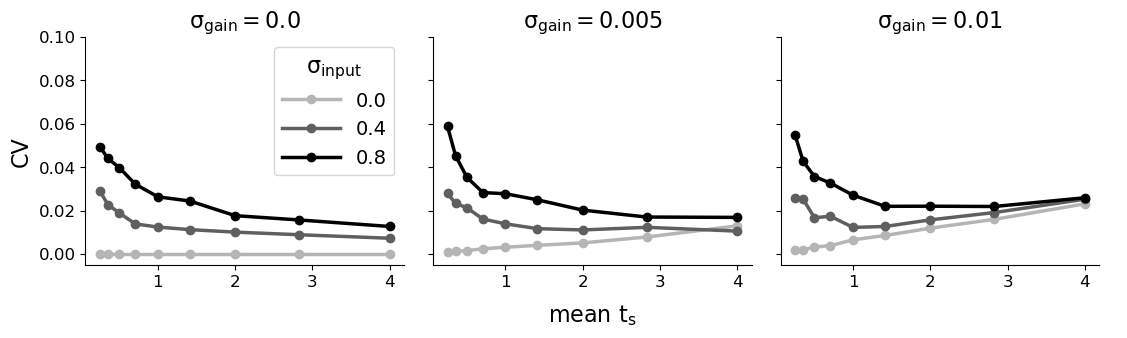

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True, sharex=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.xlabel(r'$mean\ t_s$', fontsize=16)
ax[0].set_ylabel('CV', fontsize=16)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

title = r'$\sigma_{{gain}} = {}$'
colors = plt.cm.Greys(np.linspace(0.4, 1, 3))
for i in range(0,len(between_gain_noise_std)):
    for j in range(0, len(input_noise)):
        conditions = (scalar_sensory_dt['between_gain_noise_std']==between_gain_noise_std[i]) & (scalar_motor_dt['input_noise_std']==input_noise[j]) & (scalar_motor_dt['within_gain_noise_std']==0) 
        x = scalar_sensory_dt[conditions]['effective_theta'].values
        cv = scalar_sensory_dt[conditions]['cv'].values
        
        ax[i].plot(x, cv, lw=2.5, color=colors[j],
                   label=str(input_noise[j]),
                   marker='o')
        
        ax[i].set_title(title.format(between_gain_noise_std[i]),
                       fontsize=16)
        ax[i].set_ylim([-0.005, 0.1])
        ax[i].tick_params(axis='both', which='major', labelsize=12)
        ax[i].tick_params(axis='both', which='minor', labelsize=12)
        
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)

legend = ax[0].legend(title=r'$\sigma_{input}$', fontsize=14)
plt.setp(legend.get_title(),fontsize=16)
        
#plt.suptitle('Time Production', y=1.05, fontsize=18)
fig.tight_layout()
#plt.savefig('cvplot_prospective_sensory.png', dpi=400)
#fig.savefig('cvplot_prospective_sensory.tiff', dpi=1000, bbox_inches='tight')

